## 2023 06/16 Single Cropped Palm and LBP AutoML Experimentation

*Last Updated*: 2023-09-26

### Authors
* Hannah Zhang (hannahzhang@ucsb.edu)


### Overview
This Jupyter notebook is intended to demonstrate

* Mediapipe single palm cropped images with lbp feature extraction results from automl tests


### Key Results

- Huber Regressor, Passive Aggressive Regressor, and Gradient Boosting Regressor perform the best
- Dummy Regressor 6th best

In [ ]:
# --- Imports

# External packages
from pycaret import regression
from pycaret.datasets import get_data
import os
import cv2
from dermaml import data
from dermaml import features
import PIL
from PIL import Image
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import pandas as pd
import skimage


In [3]:
dataset_name = "11khands"

experiment_name = "cropped 11khands with lbp"

num_best_models = 5
random_seed = 345

In [4]:
# Dataset
dataset_name = "11khands"

# AutoML
experiment_name = "11khands-automl-sample-test"
num_best_models = 5
random_seed = 123  # seed used for random number generators to ensure reproducibility of results in this notebook

In [5]:
def load_image_paths(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')):
                # Create the full path to the image file
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
    return image_paths

# Example usage:
image_folder = '/Users/hannahzhang/Downloads/11khands_test_ims_2/'
image_paths = load_image_paths(image_folder)

# Print the list of image paths
print(image_paths)

['/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0000003.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0000002.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0003093.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0009409.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0001045.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0003097.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0000005.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0000004.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0003096.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0001046.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0003094.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0000006.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0003095.jpg', '/Users/hannahzhang/Downloads/11khands_test_ims_2/Hand_0001047.jpg', '/Users/hannahzhang/Downloads/11k

In [6]:
cropped_ims = []
cropped_filenames = []

for path in image_paths:
    output = data.crop_palm(path)
    if output is not None:
        cropped_ims.append(output)
        filename = os.path.basename(path)
        cropped_filenames.append(filename)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


No hands detected in the image.
No hands detected in the image.
No hands detected in the image.
No hands detected in the image.
No hands detected in the image.
No hands detected in the image.
No hands detected in the image.
No hands detected in the image.


In [7]:
len(cropped_ims)

47

In [8]:
cropped_rect_ims = []

for im in cropped_ims:

    # Create a grayscale version of image
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Find contours in the grayscale image
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the coordinates of the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate the new width and height
    new_w = w // 3
    new_h = h // 3

    # Calculate the new (x, y) coordinates to keep the rectangle centered
    new_x = x + (w - new_w) // 2
    new_y = y + (h - new_h) // 2


    cropped_image = im[new_y:new_y + new_h, new_x:new_x + new_w]

    cropped_rect_ims.append(cropped_image)

In [9]:
gray_ims = []
for im in cropped_rect_ims:
    im = cv2.cvtColor(im, cv2.COLOR_RGBA2GRAY)
    gray_ims.append(im)


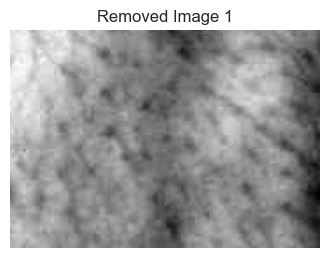

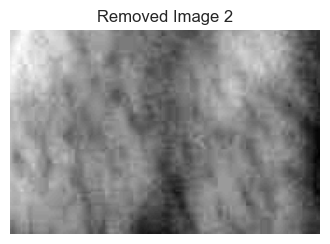

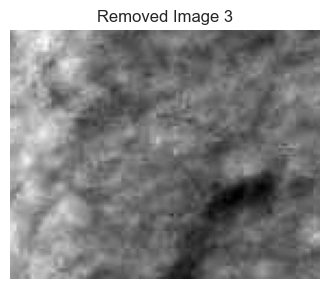

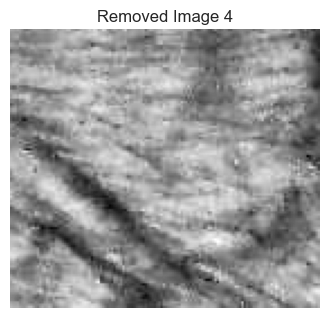

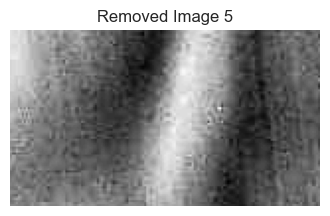

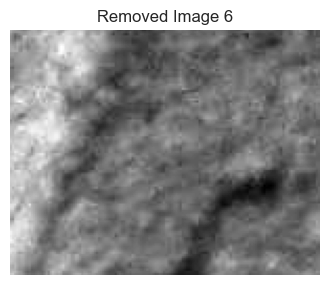

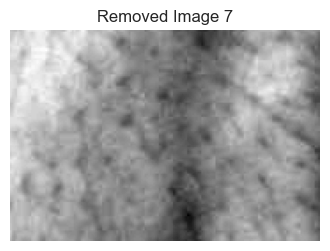

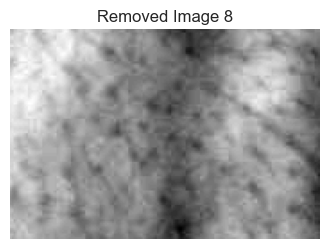

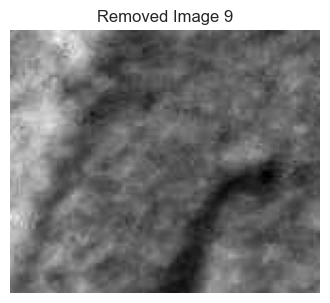

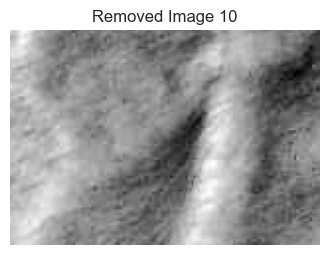

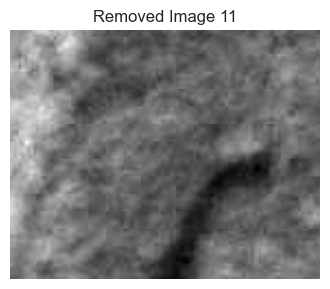

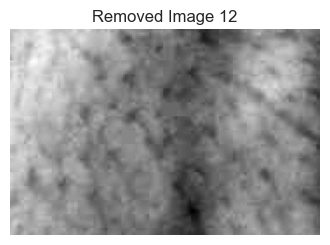

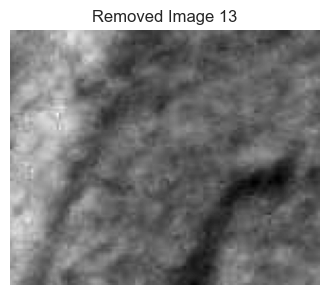

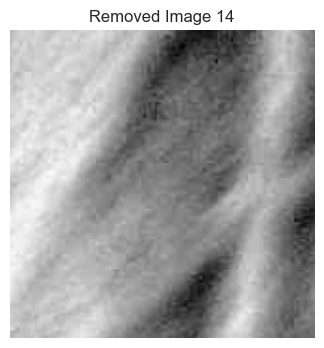

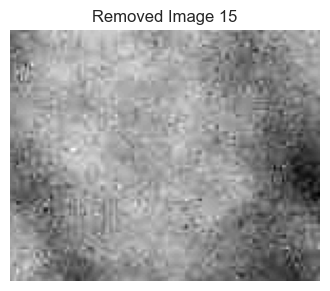

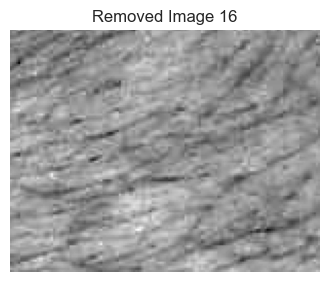

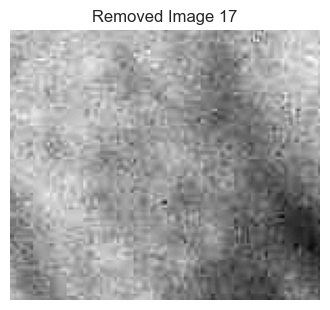

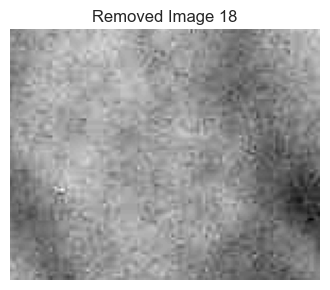

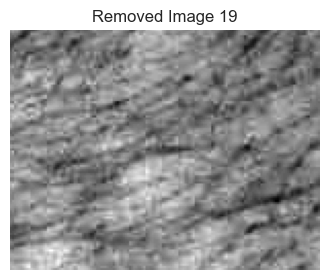

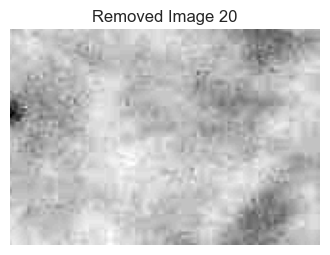

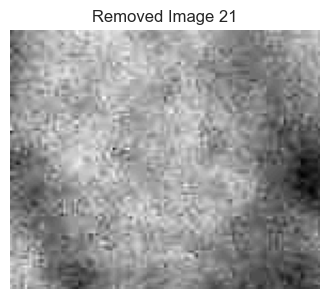

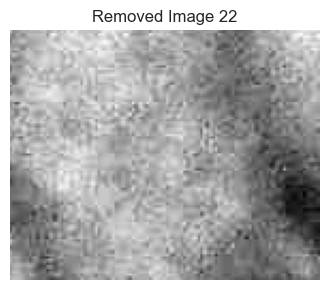

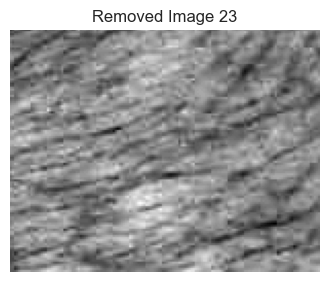

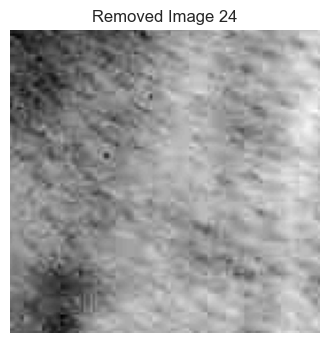

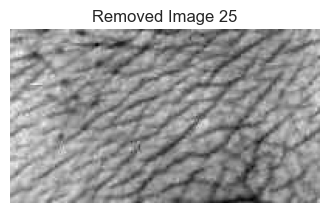

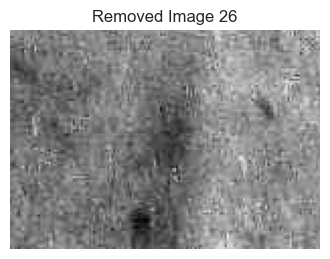

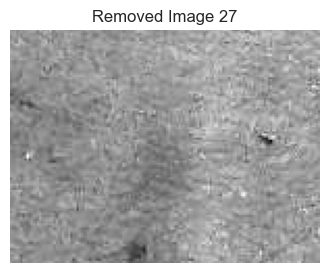

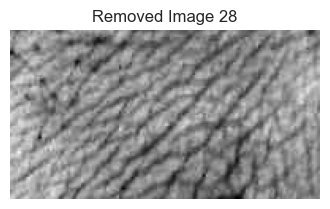

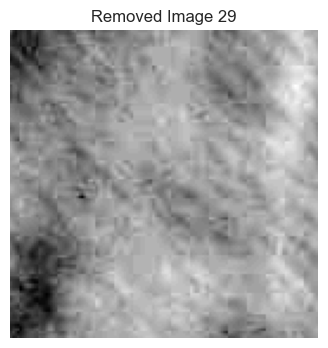

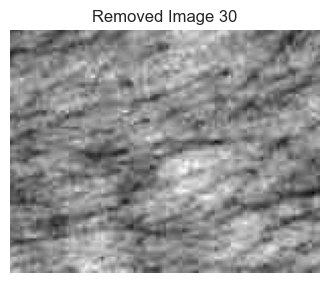

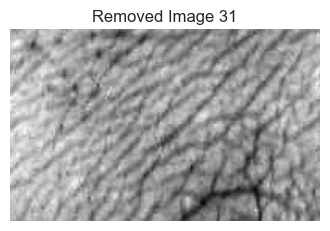

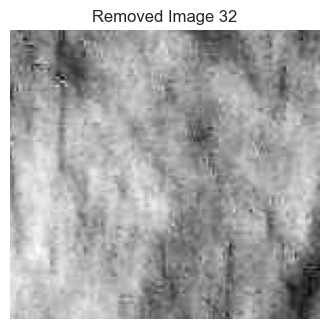

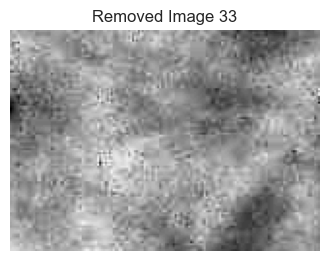

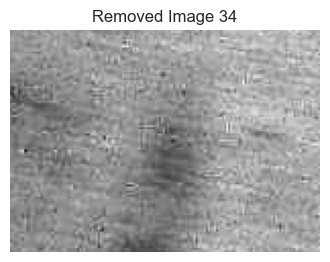

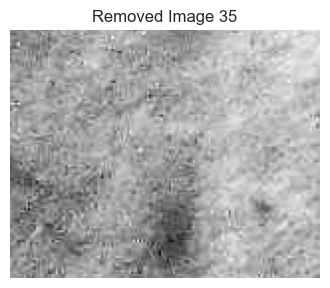

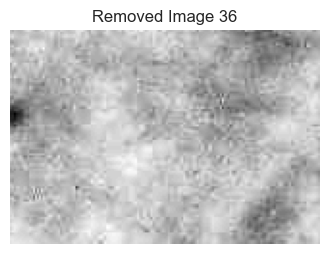

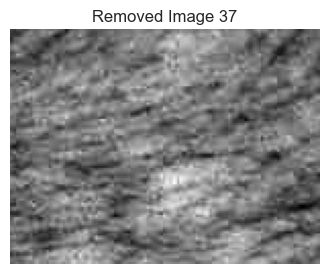

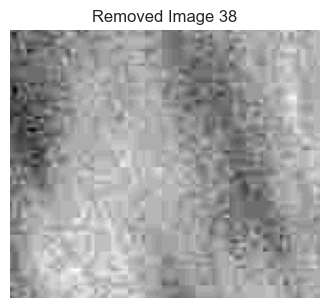

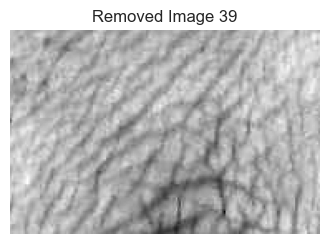

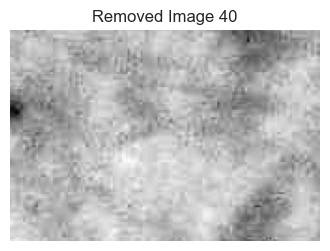

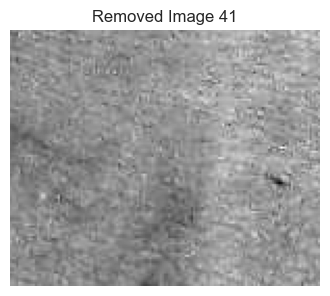

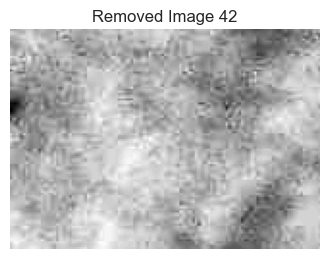

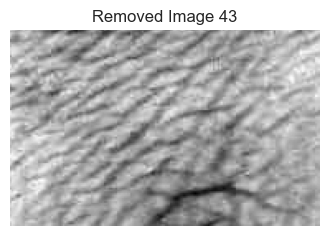

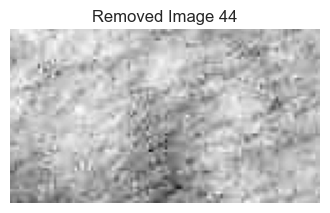

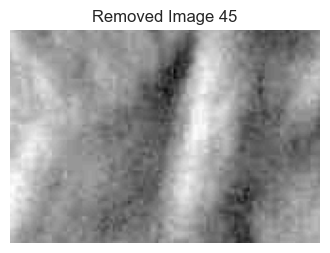

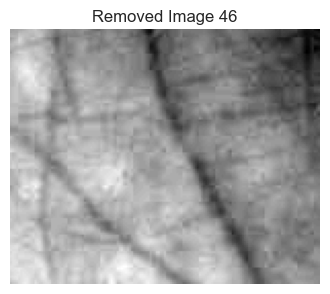

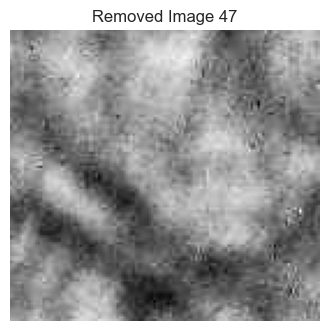

In [10]:
import matplotlib.pyplot as plt

for i, im in enumerate(gray_ims):

    plt.figure(figsize=(4, 4))
    plt.imshow(im, cmap='gray') 
    plt.title(f'Removed Image {i + 1}')
    plt.axis('off')
    plt.show()


In [12]:
lbp_features = []

for im, filename in zip(gray_ims, cropped_filenames):
    lbp = features.extract_features(im)
    lbp_features.append({
        'values': lbp,
        'filename': filename
        })

In [13]:
print(lbp_features)

[{'values': {'texture': [0.0625458211143695, 0.06442448680351906, 0.07624633431085044, 0.09150476539589443, 0.12229655425219942, 0.10882514662756598, 0.09127565982404692, 0.07936217008797654, 0.053289956011730207, 0.05819281524926686, 0.19203629032258066]}, 'filename': 'Hand_0000003.jpg'}, {'values': {'texture': [0.05818965517241379, 0.06058973354231975, 0.06754506269592477, 0.08331700626959247, 0.13440438871473354, 0.13166144200626959, 0.08973354231974921, 0.06989615987460815, 0.056475313479623826, 0.05789576802507837, 0.19029192789968652]}, 'filename': 'Hand_0000002.jpg'}, {'values': {'texture': [0.06467753891771683, 0.07369656535705461, 0.07919446503582901, 0.08710155670867309, 0.10384235235977267, 0.09717074376081047, 0.08129478626142822, 0.06467753891771683, 0.06467753891771683, 0.06140350877192982, 0.2222634049913516]}, 'filename': 'Hand_0003093.jpg'}, {'values': {'texture': [0.07965170640486209, 0.08532024310425433, 0.06241234221598878, 0.05873071528751753, 0.08888499298737727, 

Load in CSV

In [14]:
csv_file = '/Users/hannahzhang/Downloads/cropped_lbp_automl.csv'

# Read the CSV file
original_df = pd.read_csv(csv_file)

In [17]:
# Initialize empty lists
pattern_columns = []
filename_column = []

# Iterate through the list of dictionaries
for entry in lbp_features:
    texture_values = entry['values']['texture']  # Extract texture values
    filename = entry['filename']  # Extract filename

    # Add filename to the filename_column list
    filename_column.append(filename)

    # Add texture values to the pattern_columns list
    pattern_columns.append(texture_values)

# Create a DataFrame from the extracted data
lbp_df = pd.DataFrame(pattern_columns)

# Rename columns
lbp_df.columns = [f'Pattern {i}' for i in range(1, len(lbp_df.columns) + 1)]

# Add the "filename" column
lbp_df['filename'] = filename_column

# Reorder columns to have 'filename' as the first column
lbp_df = lbp_df[['filename'] + [col for col in lbp_df.columns if col != 'filename']]

print(lbp_df)

            filename  Pattern 1  Pattern 2  Pattern 3  Pattern 4  Pattern 5  \
0   Hand_0000003.jpg   0.062546   0.064424   0.076246   0.091505   0.122297   
1   Hand_0000002.jpg   0.058190   0.060590   0.067545   0.083317   0.134404   
2   Hand_0003093.jpg   0.064678   0.073697   0.079194   0.087102   0.103842   
3   Hand_0009409.jpg   0.079652   0.085320   0.062412   0.058731   0.088885   
4   Hand_0001045.jpg   0.085951   0.085808   0.055607   0.058398   0.083590   
5   Hand_0003097.jpg   0.067510   0.068434   0.071726   0.082236   0.113421   
6   Hand_0000005.jpg   0.064682   0.063049   0.075678   0.092629   0.111164   
7   Hand_0000004.jpg   0.057705   0.061212   0.075392   0.101082   0.121585   
8   Hand_0003096.jpg   0.064704   0.073787   0.074572   0.081693   0.113989   
9   Hand_0001046.jpg   0.071232   0.074680   0.066616   0.077076   0.113130   
10  Hand_0003094.jpg   0.067766   0.074623   0.073882   0.084878   0.107611   
11  Hand_0000006.jpg   0.063607   0.065511   0.07232

In [18]:
# Set the image filenames as the index
lbp_df.set_index('filename', inplace=True)

In [19]:
# Merging dataframes with different column names
merged_data = original_df.merge(lbp_df, left_on='imageName', right_on='filename', how='inner')

# Save the merged DataFrame back to the CSV file
merged_data.to_csv(csv_file, index=False)

In [20]:
print(merged_data)

    age         imageName  Pattern 1  Pattern 2  Pattern 3  Pattern 4  \
0    27  Hand_0000002.jpg   0.058190   0.060590   0.067545   0.083317   
1    27  Hand_0000003.jpg   0.062546   0.064424   0.076246   0.091505   
2    27  Hand_0000004.jpg   0.057705   0.061212   0.075392   0.101082   
3    27  Hand_0000005.jpg   0.064682   0.063049   0.075678   0.092629   
4    27  Hand_0000006.jpg   0.063607   0.065511   0.072320   0.089554   
5    20  Hand_0000080.jpg   0.114308   0.100000   0.044051   0.031026   
6    20  Hand_0000081.jpg   0.119507   0.110092   0.037663   0.020461   
7    20  Hand_0000082.jpg   0.120491   0.103244   0.043089   0.026204   
8    20  Hand_0000083.jpg   0.126019   0.106663   0.039070   0.021393   
9    20  Hand_0000084.jpg   0.120860   0.107819   0.039559   0.025754   
10   21  Hand_0000132.jpg   0.103582   0.102587   0.056219   0.043383   
11   21  Hand_0000133.jpg   0.088543   0.079490   0.052172   0.043923   
12   21  Hand_0000134.jpg   0.077811   0.074083   0

In [21]:
merged_data.drop(columns=['imageName'], inplace=True)

In [22]:
print(merged_data)

    age  Pattern 1  Pattern 2  Pattern 3  Pattern 4  Pattern 5  Pattern 6  \
0    27   0.058190   0.060590   0.067545   0.083317   0.134404   0.131661   
1    27   0.062546   0.064424   0.076246   0.091505   0.122297   0.108825   
2    27   0.057705   0.061212   0.075392   0.101082   0.121585   0.120547   
3    27   0.064682   0.063049   0.075678   0.092629   0.111164   0.112365   
4    27   0.063607   0.065511   0.072320   0.089554   0.113312   0.117835   
5    20   0.114308   0.100000   0.044051   0.031026   0.030462   0.029436   
6    20   0.119507   0.110092   0.037663   0.020461   0.024203   0.026376   
7    20   0.120491   0.103244   0.043089   0.026204   0.026023   0.030077   
8    20   0.126019   0.106663   0.039070   0.021393   0.020194   0.021632   
9    20   0.120860   0.107819   0.039559   0.025754   0.023681   0.024336   
10   21   0.103582   0.102587   0.056219   0.043383   0.046965   0.045871   
11   21   0.088543   0.079490   0.052172   0.043923   0.045905   0.058653   

Load in CSV File

In [24]:
# --- Perform AutoML Evaluation

# Set up the dataset for AutoML regression
regression.setup(data=merged_data,
                 target="age",
                 log_experiment=True,
                 experiment_name=experiment_name,
                 session_id=random_seed,
                ) 

# Automatically train, test, and evaluate models
best_models = regression.compare_models(n_select=num_best_models, verbose=False)

,Description,Value
0,Session id,123
1,Target,age
2,Target type,Regression
3,Original data shape,"(47, 12)"
4,Transformed data shape,"(47, 12)"
5,Transformed train set shape,"(32, 12)"
6,Transformed test set shape,"(15, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


Traceback (most recent call last):
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.e

In [25]:
for model in best_models:
    print(model)
    print()

HuberRegressor()

PassiveAggressiveRegressor(random_state=123)

GradientBoostingRegressor(random_state=123)

ElasticNet(random_state=123)

Lasso(random_state=123)



In [26]:
# Display score table
regression.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,9.5423,1.830568e+02,11.1492,-0.0278,0.2880,0.2685,0.006
par,Passive Aggressive Regressor,9.6063,2.054506e+02,12.3448,-0.2637,0.3086,0.2339,0.005
gbr,Gradient Boosting Regressor,7.9966,1.419404e+02,10.3245,-0.3873,0.2467,0.2257,0.009
en,Elastic Net,10.1346,1.858801e+02,12.2007,-0.5056,0.3152,0.2896,0.004
lasso,Lasso Regression,10.1346,1.858801e+02,12.2007,-0.5056,0.3152,0.2896,0.006
dummy,Dummy Regressor,10.1346,1.858801e+02,12.2007,-0.5056,0.3152,0.2896,0.004
lightgbm,Light Gradient Boosting Machine,10.1346,1.858801e+02,12.2007,-0.5056,0.3152,0.2896,0.009
llar,Lasso Least Angle Regression,10.1346,1.858801e+02,12.2007,-0.5056,0.3152,0.2896,0.004
rf,Random Forest Regressor,8.8173,1.479542e+02,10.9528,-0.5071,0.2757,0.2587,0.020
ridge,Ridge Regression,10.2548,1.867884e+02,12.2277,-0.5175,0.3162,0.2940,0.005


In [27]:
# --- Huber Regressor

huber_model = regression.create_model('huber')
huber_model_tuned = regression.tune_model(huber_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3603,16.1855,4.0231,-0.2273,0.1330,0.1192
1,18.7611,522.5784,22.8600,-0.1418,0.4926,0.4169
2,9.1585,111.9631,10.5813,0.2331,0.2763,0.2688
3,6.3543,47.4786,6.8905,0.2174,0.2097,0.2148
4,11.3288,143.2212,11.9675,-0.6611,0.3840,0.4451
5,8.4071,108.5850,10.4204,0.0208,0.2389,0.1937
6,5.0505,40.8033,6.3877,0.5597,0.2300,0.2025
7,4.5565,27.5409,5.2479,0.4771,0.1620,0.1505
8,4.9581,25.6865,5.0682,-0.1559,0.1568,0.1546


Traceback (most recent call last):
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.e

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3075,16.0254,4.0032,-0.2152,0.1321,0.1174
1,18.7571,521.9264,22.8457,-0.1404,0.4923,0.4168
2,9.1266,111.1649,10.5435,0.2386,0.2752,0.2676
3,6.3334,47.2949,6.8771,0.2204,0.2094,0.2142
4,11.3159,142.4575,11.9356,-0.6522,0.3831,0.4439
5,8.3904,108.2662,10.4051,0.0237,0.2385,0.1932
6,5.0504,40.7098,6.3804,0.5607,0.2298,0.2024
7,4.5718,27.7126,5.2643,0.4738,0.1625,0.1511
8,4.9445,25.5894,5.0586,-0.1515,0.1564,0.1540


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.e

In [28]:
# --- Passive Agressive Regressor

par_model = regression.create_model('par')
par_model_tuned = regression.tune_model(par_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.7228,11.8651,3.4446,0.1003,0.1104,0.0918
1,20.8137,721.8598,26.8674,-0.5772,0.5985,0.4154
2,9.1611,198.1256,14.0757,-0.3570,0.3398,0.1889
3,6.5785,57.6713,7.5942,0.0494,0.2141,0.1919
4,8.1899,82.3727,9.0759,0.0446,0.2838,0.2786
5,10.1619,201.4186,14.1922,-0.8164,0.3433,0.2117
6,9.9492,108.2483,10.4042,-0.1681,0.3295,0.3321
7,5.9113,63.2376,7.9522,-0.2007,0.2216,0.1604
8,5.4990,34.2553,5.8528,-0.5415,0.1780,0.1622


Traceback (most recent call last):
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.e

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4813,13.6667,3.6969,-0.0363,0.1210,0.0898
1,21.8607,722.3454,26.8765,-0.5783,0.6109,0.4814
2,9.8037,205.0363,14.3191,-0.4044,0.3477,0.2076
3,5.9781,45.5546,6.7494,0.2491,0.1956,0.1853
4,7.1106,72.7616,8.5300,0.1561,0.2619,0.2338
5,9.7854,207.5545,14.4068,-0.8717,0.3508,0.2047
6,9.0539,126.9590,11.2676,-0.3701,0.3706,0.3628
7,6.7625,59.8291,7.7349,-0.1360,0.2226,0.2057
8,2.8422,14.7289,3.8378,0.3372,0.1270,0.1021


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "/Applications/DermaML/.venv/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.e